In [1]:
# Import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import keras
import io
import cv2
import tensorflow as tf
import os
from PIL import Image
import keras.backend as K
K.set_image_data_format('channels_last')
from keras.applications.convnext import ConvNeXtTiny
from keras.applications import resnet, inception_v3, mobilenet, vgg19, convnext,efficientnet
from keras.applications.efficientnet import EfficientNetB2
from keras.applications.resnet import ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.applications.mobilenet import MobileNet
from keras.applications.vgg19 import VGG19
import h5py

In [2]:
# Read the data and get the class names
class_names = []
for i in os.listdir('PokemonData'):
    class_names.append(i)
print(class_names)

['Abra', 'Aerodactyl', 'Alakazam', 'Alolan Sandslash', 'Arbok', 'Arcanine', 'Articuno', 'Beedrill', 'Bellsprout', 'Blastoise', 'Bulbasaur', 'Butterfree', 'Caterpie', 'Chansey', 'Charizard', 'Charmander', 'Charmeleon', 'Clefable', 'Clefairy', 'Cloyster', 'Cubone', 'Dewgong', 'Diglett', 'Ditto', 'Dodrio', 'Doduo', 'Dragonair', 'Dragonite', 'Dratini', 'Drowzee', 'Dugtrio', 'Eevee', 'Ekans', 'Electabuzz', 'Electrode', 'Exeggcute', 'Exeggutor', 'Farfetchd', 'Fearow', 'Flareon', 'Gastly', 'Gengar', 'Geodude', 'Gloom', 'Golbat', 'Goldeen', 'Golduck', 'Golem', 'Graveler', 'Grimer', 'Growlithe', 'Gyarados', 'Haunter', 'Hitmonchan', 'Hitmonlee', 'Horsea', 'Hypno', 'Ivysaur', 'Jigglypuff', 'Jolteon', 'Jynx', 'Kabuto', 'Kabutops', 'Kadabra', 'Kakuna', 'Kangaskhan', 'Kingler', 'Koffing', 'Krabby', 'Lapras', 'Lickitung', 'Machamp', 'Machoke', 'Machop', 'Magikarp', 'Magmar', 'Magnemite', 'Magneton', 'Mankey', 'Marowak', 'Meowth', 'Metapod', 'Mew', 'Mewtwo', 'Moltres', 'MrMime', 'Muk', 'Nidoking', 'Ni

In [3]:
# Create the data generators
target_size = (224, 224)
batch_size = 32
# datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,horizontal_flip=True,vertical_flip = True,validation_split=0.4, rotation_range=90,width_shift_range=0.3, height_shift_range=0.3, shear_range=0.3, zoom_range=0.3, fill_mode='nearest', data_format='channels_last')
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,validation_split=0.2)
train_generator = datagen.flow_from_directory('PokemonData', target_size=target_size, batch_size=batch_size, class_mode='categorical', subset='training')
validation_generator = datagen.flow_from_directory('PokemonData', target_size=target_size, batch_size=batch_size, class_mode='categorical', subset='validation')

Found 5511 images belonging to 150 classes.
Found 1309 images belonging to 150 classes.


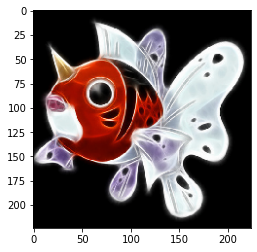

Seaking


In [4]:
# Show a sample image
sample = next(train_generator)
plt.imshow(sample[0][0])
plt.show()
print(class_names[int(np.argmax(sample[1][0]))])


In [5]:
# Define the model
def poke_model():
    pre_trained = MobileNet(input_shape = target_size + (3,), include_top = False, weights = 'imagenet')
    layers = pre_trained.layers
    for layer in layers[0:-15]:
        layer.trainable = False
    x = pre_trained.output
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(1024, activation = 'relu')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.5)(x)
    x = keras.layers.Dense(512, activation = 'relu')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.5)(x)
    x = keras.layers.Dense(256, activation = 'relu')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.5)(x)
    x = keras.layers.Dense(150, activation = 'linear')(x)
    model = keras.models.Model(pre_trained.input, x)
    return model

In [6]:
# Create the model
model = poke_model()

In [7]:
#Load the model weights
model = keras.models.load_model('transferred_poke_model.h5')

In [8]:
# Compile the model
learning_rate = 0.0001
model.compile(loss=keras.losses.CategoricalCrossentropy(from_logits=True), optimizer=keras.optimizers.Adam(learning_rate), metrics=['accuracy'])

In [9]:
# Train the model
epochs = 10
callback = tf.keras.callbacks.EarlyStopping(
    monitor='accuracy',
    patience=2,
    verbose=0,
    mode='auto',
    restore_best_weights=True,
)
# history = model.fit(train_generator,validation_data = validation_generator, epochs=epochs, verbose=1, callbacks=[callback],shuffle=True)

In [10]:
# Print the results
scores = model.evaluate(train_generator, verbose=1)
print('Train loss:', scores[0])
print('Train accuracy:', scores[1]*100)
scores = model.evaluate(validation_generator, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1]*100)

In [ ]:
# Print the accuracy and loss
# print(f"Training Accuracy: {history.history['accuracy'][-1]*100} %")
# print(f"Training Loss: {history.history['loss'][-1]}")
# print(f"Validation Accuracy: {history.history['val_accuracy'][-1]*100} %")
# print(f"Validation Loss: {history.history['val_loss'][-1]}")

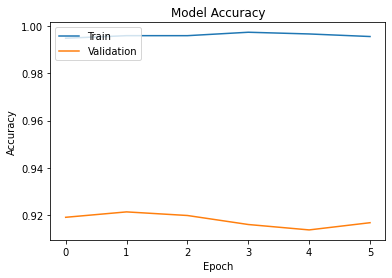

In [ ]:
# Plot the training and validation accuracy
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('Model Accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')
# plt.show()

In [ ]:
# Save the model
model.save('transferred_poke_model.h5')

In [10]:
# Make predictions
def prediction(Pokemon):
  images = os.listdir('PokemonData/' + Pokemon)
  random_image = np.random.randint(len(images))
  image = Image.open('PokemonData/' + Pokemon+'/'+images[random_image]).resize(target_size)
  image = tf.keras.preprocessing.image.img_to_array(image)/255.0
  if image.shape != (224, 224, 3) and image.shape[2] == 4:
    image = cv2.cvtColor(image, cv2.COLOR_RGBA2RGB)
  elif image.shape != (224, 224, 3):
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
  image = tf.expand_dims(image, axis=0)
  prediction = model.predict(image)
  prediction = np.argmax(prediction, axis=1)
  plt.imshow(image[0])
  plt.show()
  print('The actual class is: ' + Pokemon)
  prediction = int(prediction)
  print('The predicted class is: ' + class_names[prediction])

1/1 [==============================] - 9s 9s/step


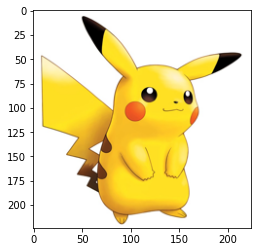

The actual class is: Pikachu
The predicted class is: Pikachu
1/1 [==============================] - 0s 41ms/step


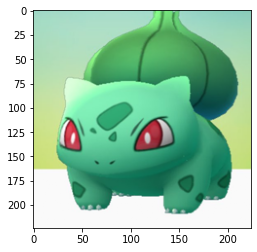

The actual class is: Bulbasaur
The predicted class is: Bulbasaur
1/1 [==============================] - 0s 72ms/step


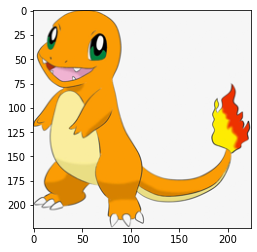

The actual class is: Charmander
The predicted class is: Charmander
1/1 [==============================] - 0s 69ms/step


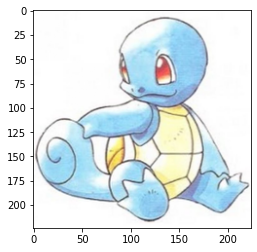

The actual class is: Squirtle
The predicted class is: Squirtle
1/1 [==============================] - 0s 27ms/step


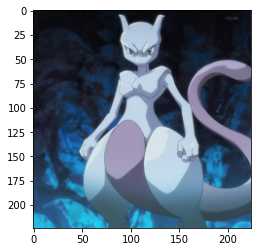

The actual class is: Mewtwo
The predicted class is: Mewtwo
1/1 [==============================] - 0s 33ms/step


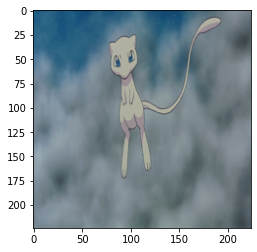

The actual class is: Mew
The predicted class is: Mew
1/1 [==============================] - 0s 28ms/step


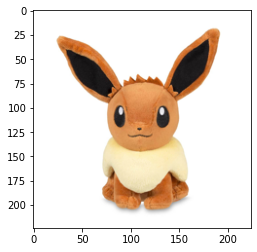

The actual class is: Eevee
The predicted class is: Eevee


In [11]:
# Check the predictions
prediction('Pikachu')
prediction('Bulbasaur')
prediction('Charmander')
prediction('Squirtle')
prediction('Mewtwo')
prediction('Mew')
prediction('Eevee')

In [12]:
# Function to predict an image present in the current directory
def predict_image(file_path):
    image = Image.open(file_path).resize(target_size)
    image = tf.keras.preprocessing.image.img_to_array(image)/255.0
    if image.shape != (224, 224, 3) and image.shape[2] == 4:
        image = cv2.cvtColor(image, cv2.COLOR_RGBA2RGB)
    elif image.shape != (224, 224, 3):
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    image = tf.expand_dims(image, axis=0)
    prediction = model.predict(image)
    prediction = np.argmax(prediction, axis=1)
    prediction = int(prediction)
    plt.imshow(image[0])
    plt.show()
    print("The actual class is: " + file_path.split('.')[0])
    print('The predicted class is: ' + class_names[prediction]) 

1/1 [==============================] - 0s 55ms/step


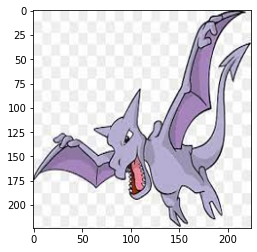

The actual class is: aerodactyl
The predicted class is: Aerodactyl
1/1 [==============================] - 0s 40ms/step


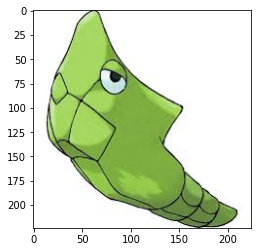

The actual class is: metapod
The predicted class is: Metapod
1/1 [==============================] - 0s 42ms/step


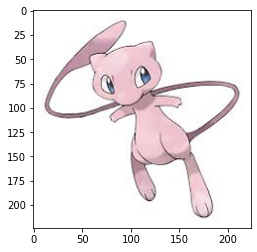

The actual class is: mew
The predicted class is: Mew
1/1 [==============================] - 0s 68ms/step


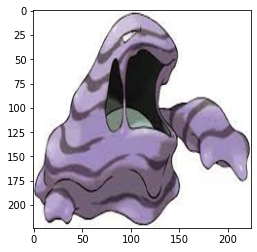

The actual class is: muk
The predicted class is: Muk
1/1 [==============================] - 0s 51ms/step


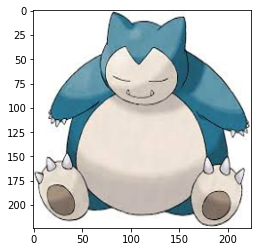

The actual class is: snorlax
The predicted class is: Snorlax
1/1 [==============================] - 0s 48ms/step


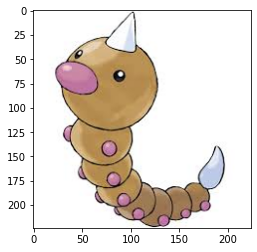

The actual class is: weedle
The predicted class is: Weedle
1/1 [==============================] - 0s 64ms/step


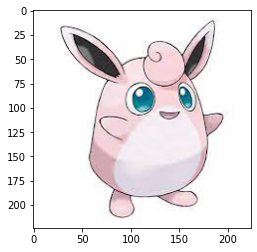

The actual class is: wigglytuff
The predicted class is: Wigglytuff


In [13]:
# Predict on new data (Not in training or validation set) (downloaded images in the current directory)
images = [image for image in os.listdir('.') if image.endswith('.jpg')]
for image in images:
    predict_image(image)

In [14]:
# Function to predict an image present in given file destination
def predict_file(file_path):
    image = Image.open(file_path).resize(target_size)
    image = tf.keras.preprocessing.image.img_to_array(image)/255.0
    if image.shape != (224, 224, 3) and image.shape[2] == 4:
        image = cv2.cvtColor(image, cv2.COLOR_RGBA2RGB)
    elif image.shape != (224, 224, 3):
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    image = tf.expand_dims(image, axis=0)
    prediction = model.predict(image)
    prediction = np.argmax(prediction, axis=1)
    prediction = int(prediction)
    plt.imshow(image[0])
    plt.show()
    print("The actual class is: " + file_path.split('/')[1].title())
    print('The predicted class is: ' + class_names[prediction]) 

In [15]:
# Function to download images from the web and predict them
import shutil
def predict():
    input_query = input()
    from bing_image_downloader import downloader
    pokemon_names = [names.lower() for names in class_names]
    if input_query.lower() in pokemon_names:
        downloader.download(input_query,limit=4,output_dir='dataset',adult_filter_off=True,force_replace=False,verbose=False)
        for image in os.listdir(f'dataset/{input_query}'):
            predict_file(f'dataset/{input_query}/'+image)
    else:
        print(f'Please enter a valid generation 1 pokemon name')
    shutil.rmtree(f'dataset/{input_query}', ignore_errors=True)

[%] Downloading Images to c:\Users\shubh\OneDrive\Desktop\Pokedex\dataset\pidgeotto


[%] Done. Downloaded 4 images.
1/1 [==============================] - 0s 34ms/step


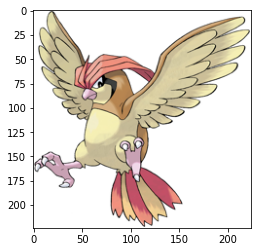

The actual class is: Pidgeotto
The predicted class is: Pidgeotto
1/1 [==============================] - 0s 39ms/step


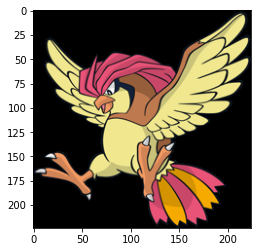

The actual class is: Pidgeotto
The predicted class is: Pidgeotto
1/1 [==============================] - 0s 42ms/step


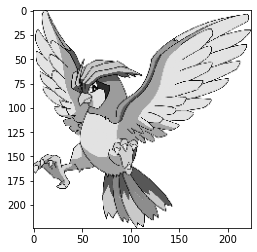

The actual class is: Pidgeotto
The predicted class is: Pidgeotto
1/1 [==============================] - 0s 32ms/step


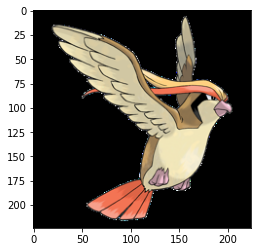

The actual class is: Pidgeotto
The predicted class is: Pidgeot


In [19]:
# Predict on new downloaded data (Not in training or validation set)
predict()